# AA3 - Práctica 1

**Andrés Lires Saborido - andres.lires@udc.es**

### Descripción

La base de datos, que se va a emplear en este trabajo, contiene mediciones hechas con un teléfono móvil inteligente. En concreto, el objetivo del problema es poder realizar el reconocimiento de la actividad que el sujeto está llevando a cabo. Esta base fue construida mediante las grabaciones recogidas de 30 sujetos con edades comprendidas entre los 19 y los 48 años en el marco de un estudio clínico. A los particiapantes se les solicito que realizaran actividades de la vida diaria mientras llevaban en la cintura mediante un cinturón un teléfono inteligente con sensores inerciales. El objetivo es clasificar las actividades en una de las seis actividades realizadas, es decir, WALKING, WALKINGUPSTAIRS, WALKINGDOWNSTAIRS, SITTING, STANDING, LAYING. Utilizando su acelerómetro y giroscopio integrados, se capturó la aceleración lineal en 3 ejes y la velocidad angular de esos mismos 3 ejes a una frecuencia constante de 50 Hz.

Las señales de los sensores (acelerómetro y giroscopio) se preprocesaron aplicando filtros de ruido y, a continuación, se muestrearon con la técnica de ventanas deslizantes de anchura fija de 2,56 segundos y con un solapamiento del 50% (128 lecturas/ventana). A partir de cada ventana, se obtuvo un vector de características calculando las variables tanto en el dominio del tiempo, como de la frecuencia. Cabe destacar que la señál de aceleración ha sido filtrada para eliminar la componente correspondiente a la gravedad y quedarse solo con el movimiento del cuerpo.

### Atributos
El primero de los atributos, es el identificador del sujeto que realizó el experimento. A continuación se tiene la aceleración triaxial del acelerómetro (aceleración total) y la aceleración corporal estimada. La velocidad angular triaxial del giroscopio. Una serie de 550 medidas y medias tomadas en el dominio del tiempo y la etiqueta con de la actividad que se estaba realizando en ese momento. Resumen del problema:

- Número de ejemplos:	10299
- Número de variables:	561
- Tipos de las variables:	Enteros, Reales y Categóticos
- Presencia de Nulos:	Sí

### Trabajo a realizar

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy.stats import kendalltau
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier



##### 1. Carga de datos

Realice una pequeña descripción de los mismos
- Número de variables
- Número de instancias    
- Número de individuos
- Número de clases de salida

In [2]:
# Cargamos el archivo Datos_Práctica_Evaluación_1.csv
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Datos_Práctica_Evaluación_1.csv')

# Breve descripción de los datos
# Numero de variables
variables = data.drop(columns=['subject', 'Activity'])
print('Número de variables: ', variables.shape[1])
# Número de instancias
print('Número de instancias: ', data.shape[0])
# Número de individuos
print('Número de individuos: ', len(data['subject'].unique()))
# Número de clases de salida
print('Número de clases de salida: ', data['Activity'].nunique())

data.describe(include='all')


Mounted at /content/drive
Número de variables:  561
Número de instancias:  10299
Número de individuos:  30
Número de clases de salida:  6


,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
count,10299.000000,10299.000000,10299.000000,10299.000000,10297.000000,10299.000000,10297.000000,10297.000000,10296.000000,10296.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAYING
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944
mean,16.146422,0.274347,-0.017743,-0.108925,-0.607824,-0.510191,-0.612991,-0.633615,-0.525692,-0.615184,...,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284,NaN
std,8.679067,0.067628,0.037128,0.053033,0.438726,0.500240,0.403662,0.413317,0.484162,0.398847,...,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898,NaN
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,9.000000,0.262625,-0.024902,-0.121019,-0.992361,-0.976990,-0.979122,-0.993293,-0.977011,-0.979084,...,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880,NaN
50%,17.000000,0.277174,-0.017162,-0.108596,-0.943076,-0.835032,-0.850239,-0.948244,-0.843576,-0.845306,...,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882,NaN
75%,24.000000,0.288354,-0.010625,-0.097589,-0.250286,-0.057336,-0.278715,-0.302055,-0.087430,-0.288176,...,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970,NaN


##### 2. Calcule el porcentaje de nulos que hay por variable y en el conjunto total de sistema.

In [3]:
# Porcentaje de nulos en total en todo el conjunto de datos
print('Porcentaje de nulos en total en todo el conjunto de datos:', data.isnull().sum().sum()/data.size*100, '%')

# En cuantas variables hay al menos un nulo
print('En cuantas variables hay al menos un nulo: ', data.isnull().any().sum())

# Porcentaje de nulos en cada variable
print('\nPorcentaje de nulos en cada variable: ')
for i in data.columns:
    print(i, ': ', data[i].isnull().sum()/data.shape[0]*100, '%')

Porcentaje de nulos en total en todo el conjunto de datos: 0.004656507546905259 %
En cuantas variables hay al menos un nulo:  131

Porcentaje de nulos en cada variable: 
subject :  0.0 %
tBodyAcc-mean()-X :  0.0 %
tBodyAcc-mean()-Y :  0.0 %
tBodyAcc-mean()-Z :  0.0 %
tBodyAcc-std()-X :  0.01941936110301971 %
tBodyAcc-std()-Y :  0.0 %
tBodyAcc-std()-Z :  0.01941936110301971 %
tBodyAcc-mad()-X :  0.01941936110301971 %
tBodyAcc-mad()-Y :  0.029129041654529564 %
tBodyAcc-mad()-Z :  0.029129041654529564 %
tBodyAcc-max()-X :  0.01941936110301971 %
tBodyAcc-max()-Y :  0.0 %
tBodyAcc-max()-Z :  0.009709680551509855 %
tBodyAcc-min()-X :  0.0 %
tBodyAcc-min()-Y :  0.0 %
tBodyAcc-min()-Z :  0.0 %
tBodyAcc-sma() :  0.009709680551509855 %
tBodyAcc-energy()-X :  0.0 %
tBodyAcc-energy()-Y :  0.0 %
tBodyAcc-energy()-Z :  0.0 %
tBodyAcc-iqr()-X :  0.029129041654529564 %
tBodyAcc-iqr()-Y :  0.009709680551509855 %
tBodyAcc-iqr()-Z :  0.0 %
tBodyAcc-entropy()-X :  0.0 %
tBodyAcc-entropy()-Y :  0.0 %
tBody

##### 3. Haga un holdout del 10% de los datos estos se reservarán hasta el final pero hágalo individual-wise, es decir: es el 10% de los individuos el que quedará fuera. Use el valor de semilla 3202 para realizar la división. Compruebe qué individuos quedan fuera

In [4]:
# Dividimos los datos en dos conjuntos: train y test individual-wise (el 10% de los individuos en test)
# con la función GroupShuffleSplit
seed = 3202
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)

split = gss.split(variables, groups=data['subject'])
train_idx, test_idx = next(split)

train = data.iloc[train_idx]
test = data.iloc[test_idx]

# Comprobamos qué individuos quedan fuera
individuos_fuera = test['subject'].unique()
print('\nNúmero de individuos que quedan fuera: ', individuos_fuera)


Número de individuos que quedan fuera:  [ 1 10 17]


##### 4. Prepare los datos para su uso en diferentes técnicas de clasificación. Aplique las técnicas de "rellenar con la media" sobre las variables enteras, "rellenado con un KNN" en las variables categóricas, "rellenado iterativo" sobre las variables reales. Sobre este paso, recuerde establecer las transformaciones sobre el conjunto de entrenamiento y, posteriormente aplicárselo al conjunto de test para no contaminar este último. Se recomienda leer la documentación sobre SimpleImputer y ColumnTransformer.

In [5]:
seed = 3202

# Identificar variables por tipo
variables_enteras = train.select_dtypes(include=['int']).columns
variables_categoricas = train.select_dtypes(exclude=['int', 'float']).columns
variables_reales = train.select_dtypes(include=['float']).columns

# Codificar las variables categóricas
le = LabelEncoder()
train.loc[:, 'Activity'] = le.fit_transform(train['Activity'])
test.loc[:, 'Activity'] = le.transform(test['Activity'])

# Crear el transformador
transformador = ColumnTransformer([
    ('enteras', SimpleImputer(strategy='mean'), variables_enteras),
    ('reales', IterativeImputer(random_state=seed, skip_complete=True), variables_reales),
    ('categoricas', KNNImputer(), variables_categoricas),
], verbose_feature_names_out=False)

train = transformador.fit_transform(train)
test = transformador.transform(test)
columnas = transformador.get_feature_names_out()


In [ ]:
train_df = pd.DataFrame(train, columns=columnas)
test_df = pd.DataFrame(test, columns=columnas)
print("Número de nulos en train ahora:", train_df.isnull().sum().sum())

Número de nulos en train ahora: 0


##### 5. Con los datos restantes, prepare un 5-Fold cross validation usando como semilla el valor 3202. Tenga presente que la división debería hacerse teniendo en cuenta las instancias de un participante no estén en más de uno de los conjuntos. Se recomienda repasar el GridSearch y el Pipeline


In [ ]:
# Cross vadidation
cv = StratifiedGroupKFold(n_splits = 5, random_state = seed, shuffle=True)

##### 6. Con cada uno de los conjuntos resultantes, realice la normalización de los datos mediante MinMaxScaler

In [ ]:
# Crear el pipeline definiendo el scaler de normalización
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', PCA()),
    ('classify', SVC())
])

##### 7. Sobre cada una de las posibilidades, realice las siguientes reducciones de dimensionalidad

**Filtrado ANOVA**

**Filtrado Mutual Information**

**Filtrado Kendall's Tau**

**Filtrado RFE con el método de LogisticRegression con una eliminación del 50% de la variables en cada pasada**

**PCA**

**ICA**

In [ ]:
reducers = {
    'ANOVA': SelectKBest(f_classif),
    'Mutual Info': SelectKBest(mutual_info_classif),
    'PCA': PCA(),
    'FastICA': FastICA(),
    'RFE': RFE(estimator=LogisticRegression(), step=0.5),
    'Kendall': SelectKBest(score_func= lambda x,y: np.apply_along_axis(kendalltau, axis=0, arr=x, y=y)[0])
}

##### 8. Cree los siguientes clasificadores los conjuntos resultantes del paso anterior.

**MLP con al menos las siguientes arquitecturas: [50], [100] [100, 50]**

**KNN con valores de vecindario entre 1, 10 y 20**

**SVM con el parámetro C con valores 0.1, 0.5 y 1.0**

##### 9. Adicionalmente, con los datos sólo con el tratamiento de Filtrado ANOVA, recrear las siguientes técnicas

**BaggingClassifier con clasificador base KNN con número de vecinos 5 y número de estimadores 10 y 50**

**AdaBoosting con estimadores SVM con kernel lineal siendo el número de estimadores 5**

In [ ]:
# Creamos las combinaciones de clsificadores

param_grid = {
    'MLP': {
        'reducers': list(reducers.values()),
        'classify': [MLPClassifier(random_state=seed)],
        'classify__hidden_layer_sizes': [[50], [100], [100,50]],
        'classify__random_state': [seed]
    },

    'KNN': {
        'reducers': list(reducers.values()),
        'classify': [KNeighborsClassifier()],
        'classify__n_neighbors': [1, 10, 20]
    },

    'SVM': {
        'reducers': list(reducers.values()),
        'classify': [SVC(random_state=seed)],
        'classify__C': [0.1, 0.5, 1]
    },

    'BAGGING_KNN':{
        'classify': [BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), random_state=seed)],
        'reducers': [reducers['ANOVA']],
        'classify__n_estimators': [10,50],
        'classify__random_state': [seed]
    },

    'ADABOOST_SVM':{
        'classify': [AdaBoostClassifier(estimator=SVC(kernel='linear', C=0.2, probability=True, random_state=seed), random_state=seed)],
        'reducers': [reducers['ANOVA']],
        'classify__n_estimators': [5],
        'classify__random_state': [seed]
}
}

In [7]:
# Separamos X Y de los conjuntos de train y test
X_train = train_df.drop(columns=['subject', 'Activity'])
y_train = train_df['Activity']


X_test = test_df.drop(columns=['subject', 'Activity'])
y_test = test_df['Activity']
train_individuo = train_df['subject']


In [ ]:
# Crear el grid search y entrenar los modelos
entrenados = {}
for model, parameters in param_grid.items():
    print('Entrenando modelo: ', model)
    grid = GridSearchCV(pipeline, parameters, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train, groups=train_individuo)
    entrenados[model] = grid
    print('Mejor modelo para ', model, ': ', grid.best_params_)
    print('Mejor accuracy para ', model, ': ', grid.best_score_)
    # Testear con accuracy
    test_accuracy = grid.score(X_test, y_test)
    print('Accuracy en test para ', model, ': ', test_accuracy)

Entrenando modelo:  MLP
Mejor modelo para  MLP :  {'classify': MLPClassifier(random_state=3202), 'classify__hidden_layer_sizes': [100], 'classify__random_state': 3202, 'reducers': PCA()}
Mejor accuracy para  MLP :  0.958996609813678
Accuracy en test para  MLP :  0.958374628344896
Entrenando modelo:  KNN


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mejor modelo para  KNN :  {'classify': KNeighborsClassifier(), 'classify__n_neighbors': 10, 'reducers': RFE(estimator=LogisticRegression(), step=0.5)}
Mejor accuracy para  KNN :  0.9120503584339884
Accuracy en test para  KNN :  0.9256689791873142
Entrenando modelo:  SVM


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mejor modelo para  SVM :  {'classify': SVC(random_state=3202), 'classify__C': 1, 'reducers': RFE(estimator=LogisticRegression(), step=0.5)}
Mejor accuracy para  SVM :  0.948383638137614
Accuracy en test para  SVM :  0.9514370664023786
Entrenando modelo:  BAGGING_KNN
Mejor modelo para  BAGGING_KNN :  {'classify': BaggingClassifier(estimator=KNeighborsClassifier(), random_state=3202), 'classify__n_estimators': 10, 'classify__random_state': 3202, 'reducers': SelectKBest()}
Mejor accuracy para  BAGGING_KNN :  0.7100039720939295
Accuracy en test para  BAGGING_KNN :  0.7086223984142715
Entrenando modelo:  ADABOOST_SVM
Mejor modelo para  ADABOOST_SVM :  {'classify': AdaBoostClassifier(estimator=SVC(C=0.2, kernel='linear', probability=True,
                                 random_state=3202),
                   random_state=3202), 'classify__n_estimators': 5, 'classify__random_state': 3202, 'reducers': SelectKBest()}
Mejor accuracy para  ADABOOST_SVM :  0.18607402282057298
Accuracy en test par

##### 10. Entrenar con el conjunto completo de entrenamiento (todo lo que componía el 5-fold cross-validation) y testear son el 10% reservado:

**Coger las 5 mejores combinaciones de los modelos anteriores de clasificación, (1 KNN, 1 SVM, 1 MLP, 1 Bagging y 1 AdaBoosting)**

In [ ]:
# Coger las mejores combinaciones de hiperparámetros para cada modelo
mejores_modelos = {}

best_MLP = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', PCA()),
    ('classify', MLPClassifier(random_state=seed, hidden_layer_sizes=[100]))
])
mejores_modelos['MLP'] = best_MLP

best_KNN = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', RFE(estimator=LogisticRegression(), step=0.5)),
    ('classify', KNeighborsClassifier(n_neighbors = 10))
])
mejores_modelos['KNN'] = best_KNN

best_SVC = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', RFE(estimator=LogisticRegression(), step=0.5)),
    ('classify', SVC(random_state=seed, C=1))
])
mejores_modelos['SVC'] = best_SVC

best_Bagging = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', SelectKBest(f_classif)),
    ('classify', BaggingClassifier(estimator = KNeighborsClassifier(n_neighbors=5), random_state=seed, n_estimators = 10))
])
mejores_modelos['Bagging'] = best_Bagging

best_AdaBoost = Pipeline([
    ('scaler', MinMaxScaler()),
    ('reducers', SelectKBest(f_classif)),
    ('classify', AdaBoostClassifier(estimator = SVC(kernel = 'linear', C = 0.2, probability = True, random_state = seed), random_state=seed, n_estimators = 5))
])
mejores_modelos['Adaboost'] = best_AdaBoost

**Crear un Random Forest con valor para los estimadores del 500 y profundidad máxima de 10**

In [ ]:
# Crear un random forest para los estimadores del 500 y profundidad maxima de 10
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=seed)
rf.fit(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)
print('Accuracy en test para Random Forest: ', test_accuracy)

Accuracy en test para Random Forest:  0.9474727452923687


**Crear un XGBoost con los valores por defecto**

In [ ]:
# Crear un XGBoost con los valores por defecto
xgb = XGBClassifier(random_state=seed)
xgb.fit(X_train, y_train)
test_accuracy = xgb.score(X_test, y_test)
print('Accuracy en test para XGBoost: ', test_accuracy)

Accuracy en test para XGBoost:  0.9494549058473737


In [ ]:
import xgboost as xgb

train_dm = xgb.DMatrix(X_train, label=y_train)
test_dm = xgb.DMatrix(X_test, label=y_test)

xgb_model = xgb.train(dtrain=train_dm, params={"num_class": 6})

y_pred = xgb_model.predict(test_dm)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy en test para XGBoost: ', accuracy)

Accuracy en test para XGBoost:  0.9098116947472745


**Crear un Hard Voting con las mejores combinaciones del KNN, SVM y MLP (uno para cada una de las técnicas)**

In [ ]:
voting_clas = [(name, model) for name, model in mejores_modelos. items()]

voting = VotingClassifier(voting_clas[0:3], voting='hard')
voting.fit(X_train, y_train)
test_accuracy = voting.score(X_test, y_test)
print('Accuracy en test para Hard Voting: ', test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy en test para Hard Voting:  0.9544103072348861


**Crear un Soft Voting con las mejores combinaciones del KNN y MLP (uno para cada una de las técnicas). Para los pesos de la votación, usar el porcentaje de acierto en test de cada una de las combinaciones en el 5-fold cross-valiadation (best_score_)**

In [ ]:
votingSoft = VotingClassifier(voting_clas[0:2], voting='soft', weights=[0.958996609813678, 0.9120503584339884])
votingSoft.fit(X_train, y_train)
test_accuracy = votingSoft.score(X_test, y_test)
print('Accuracy en test para Soft Voting: ', test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy en test para Soft Voting:  0.958374628344896


**Crear un Ensemble Stacking con MLP como clasificador final, así mismo, use como base las mejores combinaciones del SVM, KNN y MLP**

In [ ]:
stacking = StackingClassifier(estimators=voting_clas[0:3], final_estimator=mejores_modelos['MLP'])
stacking.fit(X_train, y_train)
test_accuracy = stacking.score(X_test, y_test)
print('Accuracy en test para Stacking: ', test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy en test para Stacking:  0.9663032705649157


##### 11. A mayores con el conjunto de entrenamiento compruebe en cuantas varibles se queda este  para las técnicas enumeradas en el paso 7, es decir para cada una de las técnicas de filtrado con los parámetros por defecto.

In [ ]:
X_train_sc = MinMaxScaler().fit_transform(X_train)

# ANOVA
anova = SelectKBest(f_classif)
anova.fit_transform(X_train_sc, y_train)
print('Número de variables con ANOVA: ', anova.get_support().sum())

# Mutual Info
mi = SelectKBest(mutual_info_classif)
mi.fit_transform(X_train_sc, y_train)
print('Número de variables con Mutual Info: ', mi.get_support().sum())

# PCA
pca = PCA()
pca.fit_transform(X_train_sc)
print('Número de variables con PCA: ', pca.n_components_)

# FastICA
ica = FastICA()
ica.fit_transform(X_train_sc)
print('Número de variables con FastICA: ', len(ica.components_))

# RFE
rfe = RFE(estimator=LogisticRegression(), step=0.5)
rfe.fit_transform(X_train_sc, y_train)
print('Número de variables con RFE: ', rfe.get_support().sum())

# Kendall
kendall = SelectKBest(score_func= lambda x,y: np.apply_along_axis(kendalltau, axis=0, arr=x, y=y)[0])
kendall.fit_transform(X_train_sc, y_train)
print('Número de variables con Kendall: ', kendall.get_support().sum())


Número de variables con ANOVA:  10
Número de variables con Mutual Info:  10
Número de variables con PCA:  561


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Número de variables con FastICA:  561


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Número de variables con RFE:  280
Número de variables con Kendall:  10


##### 12. También imprima la importancia de las variables seleccionadas por el Random Forest y por el XGBoost ordenadas por importancia.

In [ ]:
print('Importancia de las variables seleccionadas por Random Forest: ')
importancias = rf.feature_importances_
indices = np.argsort(importancias)[::-1]
for i in range(len(indices)):
    print(X_train.columns[indices[i]], ': ', importancias[indices[i]])

Importancia de las variables seleccionadas por Random Forest: 
tGravityAcc-min()-X :  0.03420927921535118
tGravityAcc-energy()-X :  0.0293715629412447
tGravityAcc-mean()-X :  0.02929936534561184
angle(X,gravityMean) :  0.028558536321490805
tGravityAcc-mean()-Y :  0.026193370043214946
tGravityAcc-max()-Y :  0.024003621669798254
angle(Y,gravityMean) :  0.02305313629884103
tGravityAcc-max()-X :  0.021755254716055175
tGravityAcc-min()-Y :  0.021727594366285803
tGravityAcc-energy()-Y :  0.01707427641751362
tBodyAccMag-std() :  0.010924759876029222
fBodyAccMag-energy() :  0.010904186914897654
tGravityAcc-max()-Z :  0.01001884082611898
tGravityAcc-min()-Z :  0.009918898582193955
angle(Z,gravityMean) :  0.00981144411655787
tBodyAccJerk-energy()-X :  0.009649047253730126
fBodyAccJerk-bandsEnergy()-1,16 :  0.009354738792964199
fBodyAccMag-mad() :  0.009298772845380384
tGravityAcc-arCoeff()-Z,2 :  0.009277549029666435
tGravityAcc-arCoeff()-Y,1 :  0.009020380517940246
fBodyAccJerk-bandsEnergy()-1,

In [ ]:
print('\nImportancia de las variables seleccionadas por XGBoost: ')
importancias = xgb.feature_importances_
indices = np.argsort(importancias)[::-1]
for i in range(len(indices)):
    print(X_train.columns[indices[i]], ': ', importancias[indices[i]])


Importancia de las variables seleccionadas por XGBoost: 
fBodyAccJerk-std()-Y :  0.13135415
fBodyAcc-skewness()-X :  0.07185703
fBodyAccJerk-bandsEnergy()-1,24.1 :  0.07111063
fBodyAcc-bandsEnergy()-1,8.2 :  0.05563946
tGravityAcc-mean()-X :  0.05501643
tGravityAcc-energy()-X :  0.053275585
fBodyAccMag-mad() :  0.049640235
fBodyGyro-mad()-X :  0.04626292
fBodyAccMag-std() :  0.02217556
fBodyAccJerk-bandsEnergy()-9,16.2 :  0.018439753
fBodyAcc-max()-Z :  0.015892763
tGravityAcc-max()-Y :  0.013975924
fBodyAcc-max()-X :  0.01292218
tBodyAccJerk-max()-Y :  0.012913624
fBodyGyro-maxInds-Z :  0.012694666
tGravityAcc-max()-X :  0.011471299
fBodyAcc-energy()-X :  0.011439544
tBodyAccJerk-std()-Z :  0.010749329
angle(Y,gravityMean) :  0.010286851
tGravityAcc-arCoeff()-X,1 :  0.008789836
fBodyAcc-bandsEnergy()-33,48 :  0.007893274
tBodyAcc-mad()-Y :  0.0077143316
tBodyAcc-max()-X :  0.0072080074
tBodyAcc-std()-Y :  0.006670796
fBodyAccJerk-bandsEnergy()-41,48 :  0.006317842
tBodyGyro-max()-X :

##### 13. Por último realize los gráficos de importantcia de variables tanto de Random Forest como XGBoost.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

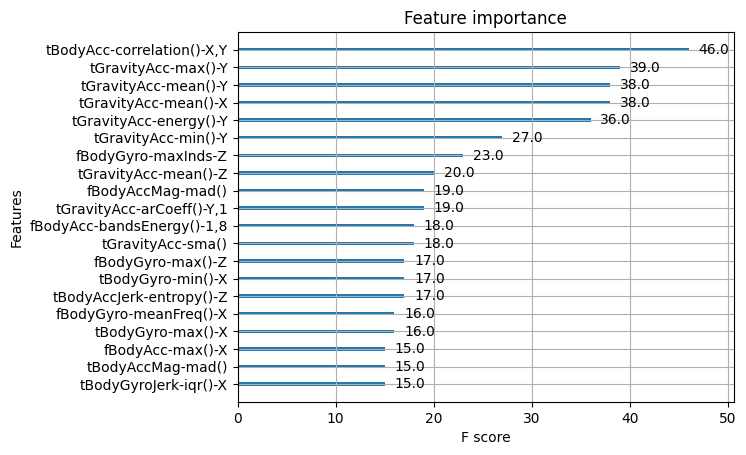

In [25]:
xgb.plot_importance(xgb_model, max_num_features = 20)

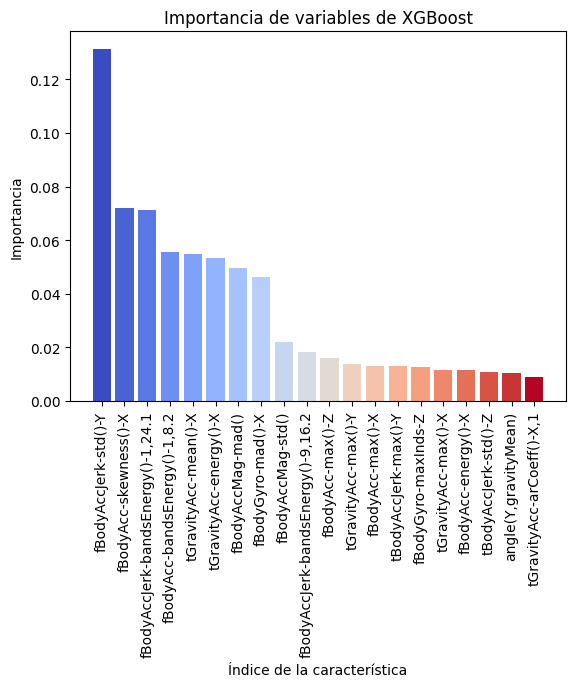

In [ ]:
indices_xgb = np.argsort(xgb.feature_importances_)[::-1]
indices_rf = np.argsort(rf.feature_importances_)[::-1]
importancias_xgb = xgb.feature_importances_[indices_xgb]
importancias_rf = rf.feature_importances_[indices_rf]

color = plt.cm.coolwarm(np.linspace(0, 1, 20))

plt.figure()
plt.bar(range(20), importancias_xgb[:20], align='center', color=color)
plt.xticks(range(20), X_train.columns[indices_xgb[:20]], rotation=90)
plt.xlabel('Índice de la característica')
plt.ylabel('Importancia')
plt.title('Importancia de variables de XGBoost')
plt.show()

Text(0.5, 1.0, 'Importancia de variables de Random Forest')

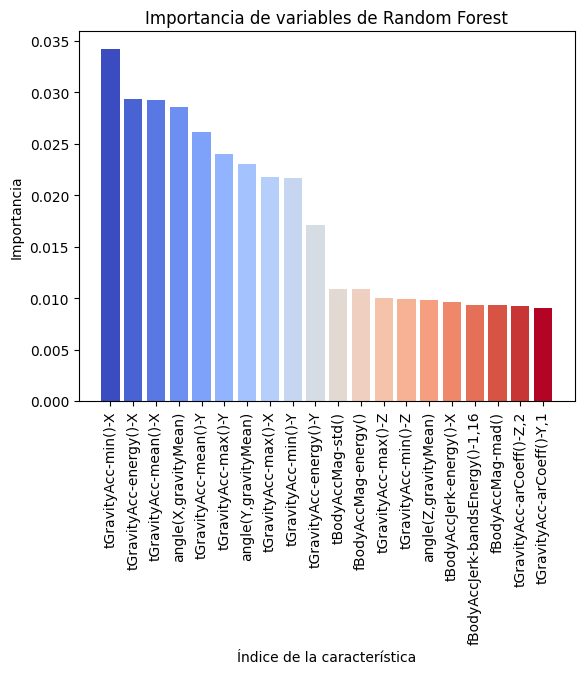

In [ ]:
plt.figure()
plt.bar(range(20), importancias_rf[:20], align='center', color=color)
plt.xticks(range(20), X_train.columns[indices_rf[:20]], rotation=90)
plt.xlabel('Índice de la característica')
plt.ylabel('Importancia')
plt.title('Importancia de variables de Random Forest')